<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [1]:
!pip3.5 install xgboost

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.sql.functions import udf
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param import Params
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import LogisticRegression
import xgboost as xgb
from scipy.sparse import csr_matrix

/usr/lib/python3.5/site-packages/xgboost/__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [4]:
DATA_PATH = '/workspace/data/criteo/dac'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [5]:
all_metrics = {}

In [6]:
!ls /workspace/data/criteo/dac

dac.tar.gz	      predictions.csv		 test.csv   xgb.model
log_reg_model	      preprocessed_data		 test.txt
logreg_xgb_xgb.model  preprocessing_transformer  train.csv
pipeline_model_2      readme.txt		 train.txt


## Baseline Model
### Prepare Data

In [7]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [8]:
df = df.sample(False, 0.5)

In [9]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [10]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [11]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'preprocessing_transformer'))

In [12]:
pipeline_model.stages

[StringIndexer_7a10a18ba99f,
 StringIndexer_2fad83565b36,
 OneHotEncoderEstimator_d6880af23e66,
 VectorAssembler_ef8ae173aa36]

In [13]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1403, 551)

Итоговая размерность пространства фичей

In [14]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

1967

In [15]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1830007

In [16]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [17]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [18]:
model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [19]:
model._call_java("booster").saveModel(os.path.join(DATA_PATH, 'xgb.model'))

### Evaluation

In [20]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [21]:
def get_ate_single(model_metrics, baseline_metrics, metrics_order):
    result = []
    for metric in metrics_order:
        delta = (model_metrics[metric] - baseline_metrics[metric]) / baseline_metrics[metric] * 100
        result.append(delta)
    return result


def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    baseline_metrics = groups[control_name]
    metrics_order = [metric for metric in baseline_metrics]
    
    metrics = pd.Series(metrics_order)
    df = {'metrics': metrics}
    for model, model_metrics in groups.items():
        df[model] = pd.Series(get_ate_single(model_metrics, baseline_metrics, metrics_order))
    return pd.DataFrame(df).set_index('metrics')

In [22]:
rocauc(model, val_df, probabilities_col='probabilities')

0.7287147712598688

In [23]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

0.7294997768780935

In [24]:
all_metrics['xgb_baseline'] = baseline_metrics

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [25]:
lr_model = LogisticRegressionModel.load(os.path.join(DATA_PATH, 'log_reg_model'))

Построить таблицу ATE используя метод `get_ate`

In [26]:
all_metrics['lr_model'] = {'ROC AUC': rocauc(lr_model, test_df, probabilities_col='probability')}
all_metrics['lr_model']

{'ROC AUC': 0.7030156663948626}

In [27]:
get_ate(all_metrics, 'xgb_baseline')

,lr_model,xgb_baseline
metrics,,
ROC AUC,-3.630448,0.0


## New Model
### Prepare Data

In [28]:
df_mte = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df_mte = df_mte.sample(False, 0.5)
df_mte = df_mte.fillna(0, subset=num_columns)

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [29]:
# Fitted Model
class MeanTargetEncoderModel(pyspark.ml.Model, DefaultParamsReadable, DefaultParamsWritable):
    
    category_mean = Param(Params._dummy(), 'category_mean', '')
    input_column = Param(Params._dummy(), 'input_column', '')
    features_column = Param(Params._dummy(), 'features_column', '')
    default_value = Param(Params._dummy(), 'default_value', 0.0)
    
    def __init__(self, category_mean= None, input_column= None, features_column= None, default_value= None):
        super(MeanTargetEncoderModel, self).__init__()
        self._resetUid(self.uid)
        if category_mean:
            self.set(self.category_mean, category_mean)
        if input_column:
            self.set(self.input_column, input_column)
        if features_column:
            self.set(self.features_column, features_column)
        if default_value:
            self.set(self.default_value, default_value)
    
    def transform(self, df):
        category_mean = self.getOrDefault(self.category_mean)
        input_column = self.getOrDefault(self.input_column)
        features_column = self.getOrDefault(self.features_column)
        default_value = self.getOrDefault(self.default_value)
        mapping = lambda x: category_mean[x] if x in category_mean else default_value
        mapping_udf = udf(mapping, FloatType())
        return df.withColumn(features_column, mapping_udf(input_column))


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):
    
    def __init__(self, input_column=None, target_column=None, features_column= None, smoothing= 1.):
        super(MeanTargetEncoder, self).__init__()
        self.input_column = input_column
        self.target_column = target_column
        self.features_column = features_column
        self.smoothing = smoothing
    
    def fit(self, df):
        targets_means = df \
            .groupby(self.input_column) \
            .agg(F.avg(self.target_column), F.count(self.target_column)) \
            .collect()

        default_value = df.agg(F.mean(self.target_column)).collect()[0][0]

        category_mean = {}
        for category, mean_value, count in targets_means:
            smoothed_mean = (mean_value * count + self.smoothing) / (count + self.smoothing / default_value)
            category_mean[category] = smoothed_mean

        return MeanTargetEncoderModel(category_mean, self.input_column, self.features_column, default_value)

#### Pipeline

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [31]:
pipeline_model = pipeline.fit(df_mte)
pipeline_model.write().overwrite().save(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [32]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [33]:
df_mte = pipeline_model \
    .transform(df_mte) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df_mte.count()

1831169

In [34]:
train_mte_df, val_mte_df, test_mte_df = split_by_col(df_mte, 'id', [0.8, 0.1, 0.1])

### Train

Train XGBoost on the new set of features

In [35]:
model_mte = estimator.fit(train_mte_df)

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [36]:
xgb_mte_metrics = {'ROC AUC': rocauc(model_mte, test_mte_df, probabilities_col='probabilities')}
all_metrics['xgb_model_mte'] = xgb_mte_metrics
all_metrics['xgb_model_mte']

{'ROC AUC': 0.7349209830338407}

In [37]:
get_ate(all_metrics, 'xgb_baseline')

,lr_model,xgb_baseline,xgb_model_mte
metrics,,,
ROC AUC,-3.630448,0.0,0.74314


# Features Importance

## [SHAP](https://github.com/slundberg/shap)

Install SHAP

In [38]:
!pip3.5 install shap

In [39]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb.model'))

[08:59:36] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [40]:
print(bst.get_dump()[0])

0:[f0<5775] yes=1,no=2,missing=2
	1:[f5<7.99999905] yes=3,no=4,missing=3
		3:[f10<1.99999905] yes=7,no=8,missing=7
			7:[f5<1.99999905] yes=15,no=16,missing=15
				15:[f3<1.99999905] yes=31,no=32,missing=31
					31:[f1416<2.00000095] yes=63,no=64,missing=64
						63:[f11<28.9999981] yes=127,no=128,missing=128
							127:[f1<11.999999] yes=251,no=252,missing=251
								251:leaf=0.0933014378
								252:leaf=0.171219513
							128:[f1<9.99999905] yes=253,no=254,missing=253
								253:leaf=-0.00455696229
								254:leaf=0.0401188694
						64:[f0<3.99999905] yes=129,no=130,missing=130
							129:[f1<61] yes=255,no=256,missing=255
								255:leaf=-0.067458868
								256:leaf=-0.0369047634
							130:[f11<2.99999905] yes=257,no=258,missing=258
								257:leaf=-0.0919239894
								258:leaf=-0.0269922893
					32:[f1517<2.00000095] yes=65,no=66,missing=66
						65:leaf=0.267741948
						66:[f10<1.99999905] yes=131,no=132,missing=132
							131:[f1416<2.00000095] yes=259,no=260,missing=26

In [41]:
sample_df = df.sample(False, 0.05)
sample_df.count()

91447

In [42]:
from scipy.sparse import csr_matrix


def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    for i, vec in enumerate(sparse_vecs):
        for idx, val in zip(vec.indices, vec.values):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
        
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [43]:
%%time
X = df_to_csr(sample_df, dim)
dtest = xgb.DMatrix(X)

CPU times: user 6.58 s, sys: 267 ms, total: 6.85 s
Wall time: 18.7 s


In [44]:
X_arr = X.toarray()

In [45]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 2min 59s, sys: 1.35 s, total: 3min
Wall time: 50 s


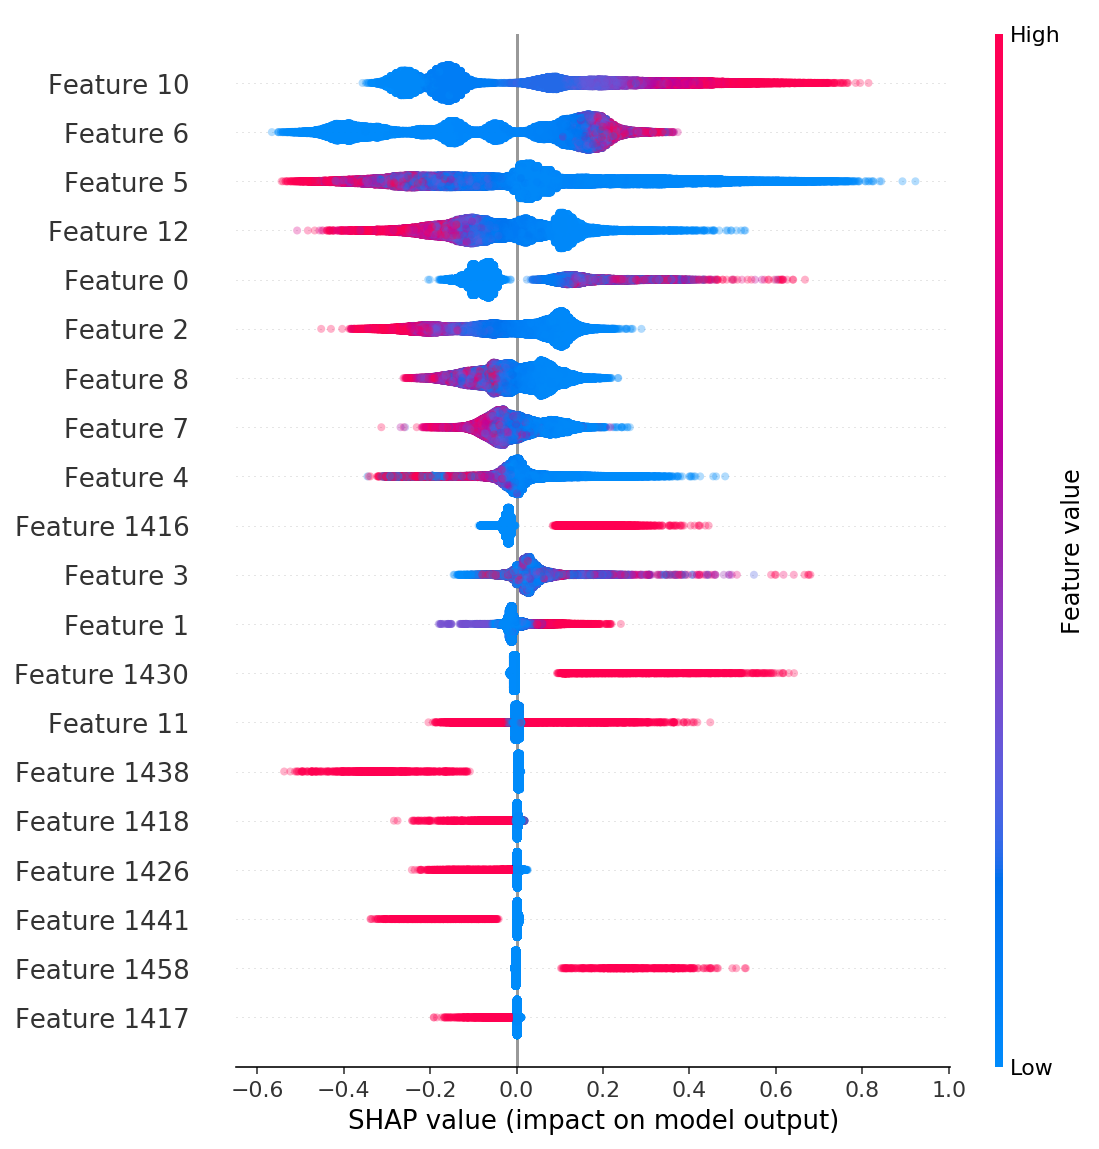

In [46]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [47]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [48]:
import pandas as pd


f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

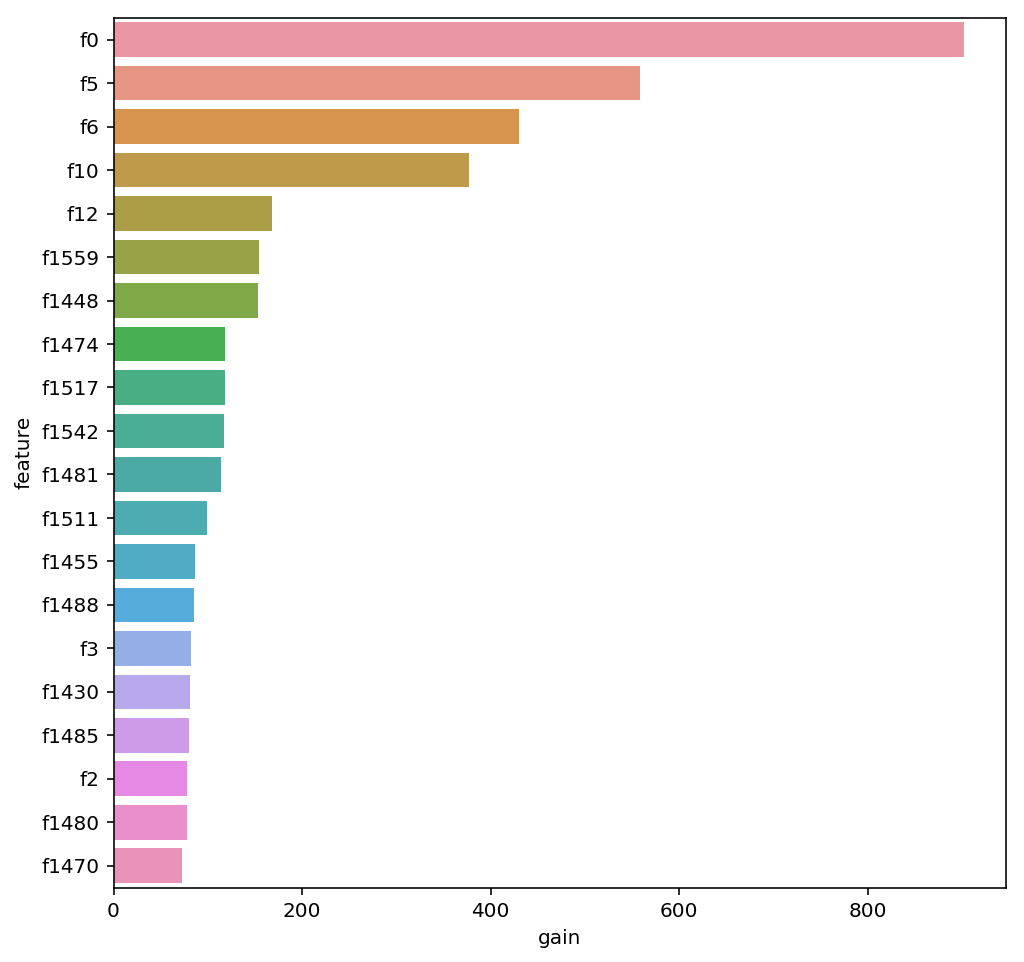

In [49]:
import seaborn as sns


_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

In [254]:
def get_booster(model):
    model._call_java("booster").saveModel("booster.tmp")
    booster = xgb.Booster()
    booster.load_model("booster.tmp")
    return booster

def get_leaves(df, booster, dim, target_values, target_column):
    X = df_to_csr(df, dim)
    predicted_leaves = booster.predict(xgb.DMatrix(X), pred_leaf=True)
    _, n_leaves = predicted_leaves.shape
    tree_columns = ['tree_%d' % i for i in range(n_leaves)]
    one_hot_columns = ['tree_%d_hot' % i for i in range(n_leaves)] 
    
    df_leaves = sqlContext.createDataFrame(
        [[target.label] + leaves.tolist() for target, leaves in zip(target_values, predicted_leaves)],
        [target_column] + tree_columns)
    return df_leaves, tree_columns, one_hot_columns


class LogRegXGBModel(pyspark.ml.Model):
    
    def __init__(self, booster, lr_model, pipeline, dim: int):
        super(LogRegXGBModel, self).__init__()
        self.booster = booster
        self.lr_model = lr_model
        self.pipeline = pipeline
        self.dim = dim
        
    def transform(self, df, target_column='label'):
        target_values = df.select(target_column).collect()
        df_leaves, _, _ = get_leaves(df, self.booster, dim, target_values, target_column)
        df_leaves_processed = self.pipeline.transform(df_leaves).select(target_column, 'features')
        return self.lr_model.transform(df_leaves_processed).drop('features')
        

class LogRegXGBEstimator(pyspark.ml.Estimator):
    
    def __init__(self, target_column, features_column, xgb_param, lr_param):
        super(LogRegXGBEstimator, self).__init__()
        self.target_column = target_column
        self.features_column = features_column
        self.xgb_param = xgb_param
        self.lr_param = lr_param
        
    def fit(self, df, dim):
        target_values = df.select(self.target_column).collect()
        
        xgb_estimator = XGBoostEstimator(**self.xgb_param)
        xgb_model = xgb_estimator.fit(df)
        booster = get_booster(xgb_model)
        
        df_leaves, tree_columns, one_hot_columns = get_leaves(df, booster, dim, target_values, self.target_column)
        
        processing_pipeline = Pipeline(stages=[
            OneHotEncoderEstimator(inputCols=tree_columns, outputCols=one_hot_columns),
            VectorAssembler(inputCols=one_hot_columns, outputCol=self.features_column)
        ])
        processing_pipeline_model = processing_pipeline.fit(df_leaves)
        
        df_leaves_processed = processing_pipeline_model.transform(df_leaves).select(self.target_column, self.features_column)
        
        lr = LogisticRegression(
            featuresCol=self.features_column, 
            labelCol=self.target_column, 
            predictionCol='prediction', 
            **self.lr_param)
        lr_model = lr.fit(df_leaves_processed)
        
        return LogRegXGBModel(booster, lr_model, processing_pipeline_model, dim)

## Train

In [261]:
sample_train_df = train_df.sample(False, 0.5)
# sample_train_df = train_df.sample(False, 0.005)
sample_train_df.count()

732816

In [262]:
sample_test_df = test_df
# sample_test_df = test_df.sample(False, 0.005)
sample_test_df.count()

183000

In [263]:
xgb_params = {
    'featuresCol': "features", 
    'labelCol': "label", 
    'predictionCol': "prediction",
    'colsample_bytree': 0.9,
    'eta': 0.15,
    'gamma': 0.9,
    'max_depth': 8,
    'min_child_weight': 50.0,
    'subsample': 0.9,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss', 
    'silent': 0,
    'num_round': 20,
    'nthread': 1,
    'nworkers': 1
}

lr_params = {
    'maxIter': 20,
    'regParam': 0.01, 
    'elasticNetParam': 0.1
}

In [264]:
lrxgb_estimator = LogRegXGBEstimator('label', 'features', xgb_params, lr_params)
lrxgb_model = lrxgb_estimator.fit(sample_train_df, dim)

[11:03:04] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [265]:
lrxgb_metrics = {'ROC AUC': rocauc(lrxgb_model, sample_test_df, probabilities_col='probability')}
all_metrics['lrxgb_model'] = lrxgb_metrics
all_metrics['lrxgb_model']

{'ROC AUC': 0.730326238271158}

In [271]:
get_ate(all_metrics, 'xgb_baseline')

,lr_model,lrxgb_model,xgb_baseline,xgb_model_mte
metrics,,,,
calibration,-3.630448,0.113292,0.0,0.74314
ROC AUC,NaN,NaN,NaN,NaN


## Evaluation

In [267]:
def calibration(model, df):
    pred_df = model.transform(df)
    sum_pred, sum_label = pred_df.groupBy().sum('prediction', 'label').head()
    return sum_pred / sum_label

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [269]:
all_metrics['xgb_baseline']['calibration'] = calibration(model, test_df)
all_metrics['lr_model']['calibration'] = calibration(lr_model, test_df)
all_metrics['xgb_model_mte']['calibration'] = calibration(model_mte, test_mte_df)
all_metrics['lrxgb_model']['calibration'] = calibration(lrxgb_model, test_df)

In [272]:
print(all_metrics)

{'lrxgb_model': {'calibration': 0.3492993788307159, 'ROC AUC': 0.730326238271158}, 'xgb_model_mte': {'calibration': 0.35962660926439544, 'ROC AUC': 0.7349209830338407}, 'xgb_baseline': {'calibration': 0.3167344243349774, 'ROC AUC': 0.7294997768780935}, 'lr_model': {'calibration': 0.21864746063520235, 'ROC AUC': 0.7030156663948626}}


In [273]:
def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    baseline_metrics = groups[control_name]
    metrics = pd.Series([metric for metric in baseline_metrics])
    
    df = {'metrics': metrics}
    for model, model_metrics in groups.items():
        df[model] = pd.Series([
            (model_metrics[metric] - baseline_metrics[metric]) / baseline_metrics[metric] * 100
            for metric in metrics
        ])
    return pd.DataFrame(df).set_index('metrics')

In [284]:
def get_ate_single(model_metrics, baseline_metrics, metrics_order):
    result = []
    for metric in metrics_order:
        delta = (model_metrics[metric] - baseline_metrics[metric]) / baseline_metrics[metric] * 100
        result.append(delta)
    return result


def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    baseline_metrics = groups[control_name]
    metrics_order = [metric for metric in baseline_metrics]
    
    metrics = pd.Series(metrics_order)
    df = {'metrics': metrics}
    for model, model_metrics in groups.items():
        df[model] = pd.Series(get_ate_single(model_metrics, baseline_metrics, metrics_order))
    return pd.DataFrame(df).set_index('metrics')

In [285]:
res = get_ate(all_metrics, 'xgb_baseline')

In [286]:
res["lr_model"]

metrics
calibration   -30.968204
ROC AUC        -3.630448
Name: lr_model, dtype: float64